# Handling Bias Data

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/acetylcholinesterase-QSAR/notebooks/4.1-Data-bias-handling.ipynb)

## 1. Load Libraries

In [1]:
!pip install rdkit

In [2]:
!pip install mols2grid

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.ML.Cluster import Butina
from rdkit.Chem.Scaffolds import MurckoScaffold
import mols2grid
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)

import rdkit
rdkit.__version__

'2023.09.1'

## 2. Load Data

In [4]:
data = PandasTools.LoadSDF('/content/data_to_train.sdf', molColName='Molecule')

,molecule_chembl_id,curated_smiles,class,Label,pIC50,ID,Molecule
0,CHEMBL4468781,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5cc(Cl)cc...,active,1,5.30103,,
1,CHEMBL199670,O=C(CCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2...,active,1,5.30103,,
2,CHEMBL199861,O=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.30103,,
3,CHEMBL4469239,S=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.30103,,
4,CHEMBL4780352,COc1cc2c(cc1OC)C(=O)C(=Cc1ccc(OCCCCN[N+]3(C)CC...,active,1,5.30103,,
...,...,...,...,...,...,...,...
5458,CHEMBL102637,CCSC(=O)OCC[N+](C)(C)C,inactive,0,-7.0,,
5459,CHEMBL334938,C[N+]1(C)CCOC(O)(c2ccc(C#N)cc2)C1,inactive,0,-7.064,,
5460,CHEMBL3597055,COC(=O)C1C(=Nc2ccc(F)cc2)CC(c2ccccc2)N(c2ccc(F...,inactive,0,-7.179552,,
5461,CHEMBL1276534,O=C(NP(=O)(NN1CCOCC1)NN1CCOCC1)c1ccccc1,inactive,0,-7.26998,,

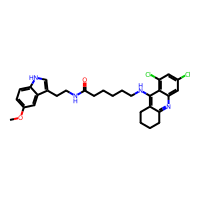
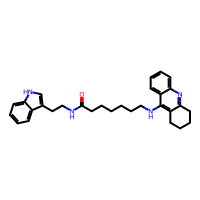
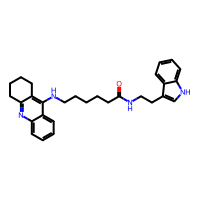
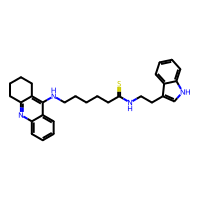
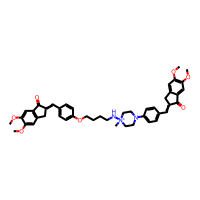
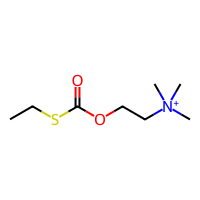
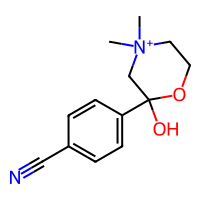
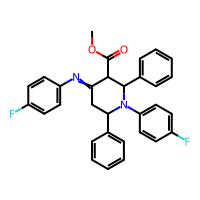
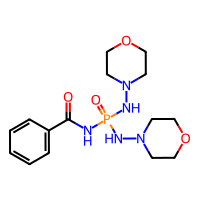
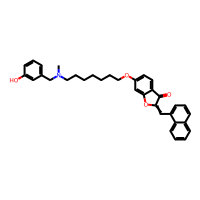

In [5]:
data

In [6]:
data.dtypes

molecule_chembl_id    object
curated_smiles        object
class                 object
Label                 object
pIC50                 object
ID                    object
Molecule              object
dtype: object

In [7]:
data['Label'] = data['Label'].astype('int')

In [8]:
data['pIC50'] = data['pIC50'].astype('float64')

## 3. Pairwise Chemical Similarity

### 3.1 Mordred descriptors

#### 3.1.1 Split data

In [9]:
X = data.drop('Label', axis=1)
y = data['Label']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

In [12]:
X_train.shape

(4370, 6)

In [13]:
X_train

,molecule_chembl_id,curated_smiles,class,pIC50,ID,Molecule
1046,CHEMBL3752356,COc1cccc2cc(CNCCCCCCNc3c4c(nc5ccccc35)CCC4)oc12,active,-1.800029,,<rdkit.Chem.rdchem.Mol object at 0x7b7c29bcfd80>
3944,CHEMBL418068,O=C(O)c1cc(O)c2c(c1)C(=O)c1cccc(O)c1C2=O,active,-4.000000,,<rdkit.Chem.rdchem.Mol object at 0x7b7c29906650>
2886,CHEMBL4443013,Oc1ccc(CNC2CCN(Cc3ccccc3)CC2)c(O)c1,active,-3.361728,,<rdkit.Chem.rdchem.Mol object at 0x7b7c299e1150>
3927,CHEMBL4164010,O=CC1CCN(Cc2cc(Cl)c3ccccc3n2)CC1,active,-4.000000,,<rdkit.Chem.rdchem.Mol object at 0x7b7c29905d90>
3606,CHEMBL1086358,CC(=NO)c1ccc(Cl)c(NC(=O)c2c(-c3ccccc3Cl)noc2C)c1,active,-3.826075,,<rdkit.Chem.rdchem.Mol object at 0x7b7c298a6a40>
...,...,...,...,...,...,...
2088,CHEMBL4571742,COc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2...,active,-2.755875,,<rdkit.Chem.rdchem.Mol object at 0x7b7c29af33e0>
220,CHEMBL4748114,COc1cc(CNC(=O)CCCCCCCNc2c3c(nc4cc(Cl)ccc24)CC2...,active,-0.287802,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a7c4ba0>
4872,CHEMBL4796237,OC1CCN(Cc2ccccc2)CC1,inactive,-5.000000,,<rdkit.Chem.rdchem.Mol object at 0x7b7c297ff530>
1829,CHEMBL141622,O=C(Nc1cccc2c1C(=O)N(CCC1CCN(Cc3ccccc3)CC1)C2=...,active,-2.531479,,<rdkit.Chem.rdchem.Mol object at 0x7b7c29ab58c0>


In [14]:
y_train.shape

(4370,)

In [15]:
X_test.shape

(1093, 6)

In [16]:
y_test.shape

(1093,)

#### 3.1.1 Chemical Similarities - Morgan radius = 2

In [17]:
morgan_r2_train = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in X_train['Molecule']]

In [18]:
len(morgan_r2_train)

4370

In [19]:
id_list_train = list(X_train['molecule_chembl_id'])
len(id_list_train)

4370

In [20]:
morgan_r2_test = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in X_test['Molecule']]
len(morgan_r2_test)

1093

In [21]:
id_list_test = list(X_test['molecule_chembl_id'])
len(id_list_test)

1093

In [22]:
tc, id = [], []

for i, (fnpr_train, id_train) in enumerate(zip(morgan_r2_train, id_list_train)):
    for j, (fnpr_test, id_test) in enumerate(zip(morgan_r2_test, id_list_test)):
        id.append((id_train, id_test))
        tc.append(DataStructs.FingerprintSimilarity(fnpr_train, fnpr_test))

In [23]:
len(tc)

4776410

In [24]:
len(id)

4776410

In [25]:
similarity_r2 = pd.DataFrame(tc, columns=['Tanimoto'])

In [26]:
similarity_r2['ID'] = id

In [27]:
similarity_r2

,Tanimoto,ID
0,0.163043,"(CHEMBL3752356, CHEMBL176521)"
1,0.159574,"(CHEMBL3752356, CHEMBL3822559)"
2,0.144330,"(CHEMBL3752356, CHEMBL3133444)"
3,0.136842,"(CHEMBL3752356, CHEMBL379563)"
4,0.093750,"(CHEMBL3752356, CHEMBL326868)"
...,...,...
4776405,0.102564,"(CHEMBL3343884, CHEMBL164660)"
4776406,0.219780,"(CHEMBL3343884, CHEMBL576385)"
4776407,0.252632,"(CHEMBL3343884, CHEMBL218940)"
4776408,0.192308,"(CHEMBL3343884, CHEMBL3920662)"


In [28]:
sorted_tc = similarity_r2.sort_values(by='Tanimoto', ascending=False)

In [29]:
sorted_tc

,Tanimoto,ID
1124731,1.0,"(CHEMBL3415559, CHEMBL3415561)"
3835478,1.0,"(CHEMBL3233829, CHEMBL3233832)"
3323228,1.0,"(CHEMBL5221017, CHEMBL4083306)"
4535686,1.0,"(CHEMBL601410, CHEMBL105257)"
2883026,1.0,"(CHEMBL224347, CHEMBL390598)"
...,...,...
2289318,0.0,"(CHEMBL322628, CHEMBL355821)"
2587103,0.0,"(CHEMBL344196, CHEMBL1191355)"
2289259,0.0,"(CHEMBL322628, CHEMBL3958208)"
2905802,0.0,"(CHEMBL139684, CHEMBL1383041)"


In [30]:
tc_equal_1 = similarity_r2.loc[similarity_r2['Tanimoto'] == 1.0]
tc_equal_1

,Tanimoto,ID
20801,1.0,"(CHEMBL3415560, CHEMBL3415561)"
131380,1.0,"(CHEMBL4467520, CHEMBL3585374)"
131844,1.0,"(CHEMBL4467520, CHEMBL3585375)"
140002,1.0,"(CHEMBL1083067, CHEMBL1083066)"
141883,1.0,"(CHEMBL3632849, CHEMBL3632850)"
...,...,...
4664376,1.0,"(CHEMBL3093798, CHEMBL3093794)"
4664384,1.0,"(CHEMBL3093798, CHEMBL3093797)"
4730824,1.0,"(CHEMBL1084093, CHEMBL1083790)"
4731196,1.0,"(CHEMBL1084093, CHEMBL258928)"


In [31]:
data.loc[(data['molecule_chembl_id'] == 'CHEMBL3415560') | (data['molecule_chembl_id'] == 'CHEMBL3415561')]

,molecule_chembl_id,curated_smiles,class,Label,pIC50,ID,Molecule
1769,CHEMBL3415560,O=C1c2ccccc2C(=O)N1CCCCCCCNCc1ccccc1,active,1,-2.481443,,<rdkit.Chem.rdchem.Mol object at 0x7b7c29a9b450>
2000,CHEMBL3415561,O=C1c2ccccc2C(=O)N1CCCCCCCCNCc1ccccc1,active,1,-2.695482,,<rdkit.Chem.rdchem.Mol object at 0x7b7c29adbd10>


In [32]:
mols = []

for id1, id2 in tc_equal_1['ID']:
    loc = data.loc[(data['molecule_chembl_id'] == id1) | (data['molecule_chembl_id'] == id2)]
    smiles1 = loc[loc['molecule_chembl_id'] == id1]['curated_smiles'].iloc[0]
    smiles2 = loc[loc['molecule_chembl_id'] == id2]['curated_smiles'].iloc[0]
    mols.extend((smiles1, smiles2))

In [33]:
mols_df = pd.DataFrame(mols, columns=['SMILES'])
mols_df

,SMILES
0,O=C1c2ccccc2C(=O)N1CCCCCCCNCc1ccccc1
1,O=C1c2ccccc2C(=O)N1CCCCCCCCNCc1ccccc1
2,Cc1ccc2[nH]c3c(c2c1)CN(CCCCCN1CCc2[nH]c4ccc(C)...
3,Cc1ccc2[nH]c3c(c2c1)CN(CCCCCCN1CCc2[nH]c4ccc(C...
4,Cc1ccc2[nH]c3c(c2c1)CN(CCCCCN1CCc2[nH]c4ccc(C)...
...,...
515,NCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2
516,NCCCCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2
517,NCCCCCCCCNc1c2c(nc3ccccc13)CCCC2
518,COc1cc(CNC(=O)CCCCCCCNc2c3c(nc4cc(Cl)ccc24)CC2...


In [34]:
mols2grid.display(mols_df, subset=['SMILES'])

MolGridWidget()

#### 3.1.2 Chemical Similarities - Morgan radius = 3

In [35]:
morgan_r3_train = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, 1024) for mol in X_train['Molecule']]

In [36]:
len(morgan_r3_train)

4370

In [37]:
id_list_train = list(X_train['molecule_chembl_id'])
len(id_list_train)

4370

In [38]:
morgan_r3_test = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, 1024) for mol in X_test['Molecule']]
len(morgan_r3_test)

1093

In [39]:
id_list_test = list(X_test['molecule_chembl_id'])
len(id_list_test)

1093

In [40]:
tc, id = [], []

for i, (fnpr_train, id_train) in enumerate(zip(morgan_r3_train, id_list_train)):
    for j, (fnpr_test, id_test) in enumerate(zip(morgan_r3_test, id_list_test)):
        id.append((id_train, id_test))
        tc.append(DataStructs.FingerprintSimilarity(fnpr_train, fnpr_test))

In [41]:
len(tc)

4776410

In [42]:
len(id)

4776410

In [43]:
similarity_r3 = pd.DataFrame(tc, columns=['Tanimoto'])

In [44]:
similarity_r3['ID'] = id

In [45]:
similarity_r3

,Tanimoto,ID
0,0.117647,"(CHEMBL3752356, CHEMBL176521)"
1,0.136691,"(CHEMBL3752356, CHEMBL3822559)"
2,0.112676,"(CHEMBL3752356, CHEMBL3133444)"
3,0.109489,"(CHEMBL3752356, CHEMBL379563)"
4,0.070922,"(CHEMBL3752356, CHEMBL326868)"
...,...,...
4776405,0.066667,"(CHEMBL3343884, CHEMBL164660)"
4776406,0.169118,"(CHEMBL3343884, CHEMBL576385)"
4776407,0.197183,"(CHEMBL3343884, CHEMBL218940)"
4776408,0.166667,"(CHEMBL3343884, CHEMBL3920662)"


In [46]:
sorted_tc = similarity_r3.sort_values(by='Tanimoto', ascending=False)

In [47]:
sorted_tc

,Tanimoto,ID
716954,1.0,"(CHEMBL3093799, CHEMBL3093802)"
1890166,1.0,"(CHEMBL153934, CHEMBL157336)"
3366186,1.0,"(CHEMBL1642976, CHEMBL594629)"
2287790,1.0,"(CHEMBL3303094, CHEMBL3233832)"
3261378,1.0,"(CHEMBL3642040, CHEMBL3642053)"
...,...,...
988231,0.0,"(CHEMBL167911, CHEMBL75985)"
2152298,0.0,"(CHEMBL3752908, CHEMBL1025)"
3780434,0.0,"(CHEMBL828, CHEMBL135086)"
3890168,0.0,"(CHEMBL2419688, CHEMBL1025)"


In [48]:
tc_equal_1 = similarity_r3.loc[similarity_r3['Tanimoto'] == 1.0]
tc_equal_1

,Tanimoto,ID
20801,1.0,"(CHEMBL3415560, CHEMBL3415561)"
237410,1.0,"(CHEMBL1257413, CHEMBL1257766)"
249594,1.0,"(CHEMBL1819171, CHEMBL1819173)"
320390,1.0,"(CHEMBL3234039, CHEMBL3233832)"
360919,1.0,"(CHEMBL1257525, CHEMBL1257766)"
...,...,...
4598641,1.0,"(CHEMBL1819172, CHEMBL1819173)"
4664376,1.0,"(CHEMBL3093798, CHEMBL3093794)"
4664384,1.0,"(CHEMBL3093798, CHEMBL3093797)"
4730824,1.0,"(CHEMBL1084093, CHEMBL1083790)"


In [49]:
mols = []

for id1, id2 in tc_equal_1['ID']:
    loc = data.loc[(data['molecule_chembl_id'] == id1) | (data['molecule_chembl_id'] == id2)]
    smiles1 = loc[loc['molecule_chembl_id'] == id1]['curated_smiles'].iloc[0]
    smiles2 = loc[loc['molecule_chembl_id'] == id2]['curated_smiles'].iloc[0]
    mols.extend((smiles1, smiles2))

In [50]:
mols_df = pd.DataFrame(mols, columns=['SMILES'])
mols_df

,SMILES
0,O=C1c2ccccc2C(=O)N1CCCCCCCNCc1ccccc1
1,O=C1c2ccccc2C(=O)N1CCCCCCCCNCc1ccccc1
2,CCCCCCCCCCCCCNc1c2c(nc3ccc(OC)cc13)CCCC2
3,CCCCCCCCNc1c2c(nc3ccc(OC)cc13)CCCC2
4,c1ccc2c(NCCCCCCCCN3CCOCC3)c3c(nc2c1)CCCC3
...,...
219,c1cc[n+](CCCCCCCCCC[n+]2ccc3ccccc3c2)cc1
220,NCCCCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2
221,NCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2
222,NCCCCCCCCCCCCNc1c2c(nc3ccccc13)CCCC2


In [51]:
mols2grid.display(mols_df, subset=['SMILES'])

MolGridWidget()

## 4. Murcko Scaffold

In [52]:
data['Murcko Scaffold'] = data['Molecule'].apply(lambda x: MurckoScaffold.GetScaffoldForMol(x))

,molecule_chembl_id,curated_smiles,class,Label,pIC50,ID,Molecule,Murcko Scaffold
0,CHEMBL4468781,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5cc(Cl)cc...,active,1,5.301030,,,
1,CHEMBL199670,O=C(CCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2...,active,1,5.301030,,,
2,CHEMBL199861,O=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.301030,,,
3,CHEMBL4469239,S=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.301030,,,
4,CHEMBL4780352,COc1cc2c(cc1OC)C(=O)C(=Cc1ccc(OCCCCN[N+]3(C)CC...,active,1,5.301030,,,
...,...,...,...,...,...,...,...,...
5458,CHEMBL102637,CCSC(=O)OCC[N+](C)(C)C,inactive,0,-7.000000,,,
5459,CHEMBL334938,C[N+]1(C)CCOC(O)(c2ccc(C#N)cc2)C1,inactive,0,-7.064000,,,
5460,CHEMBL3597055,COC(=O)C1C(=Nc2ccc(F)cc2)CC(c2ccccc2)N(c2ccc(F...,inactive,0,-7.179552,,,
5461,CHEMBL1276534,O=C(NP(=O)(NN1CCOCC1)NN1CCOCC1)c1ccccc1,inactive,0,-7.269980,,,

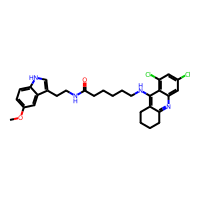
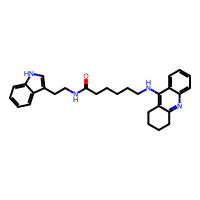
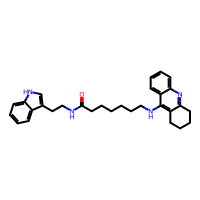
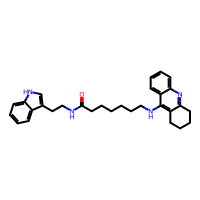
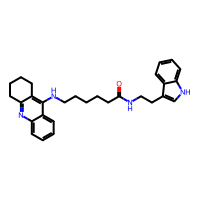
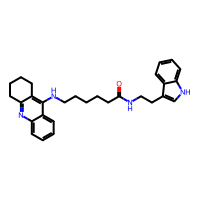
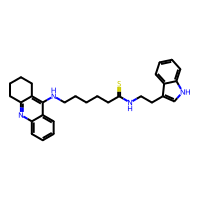
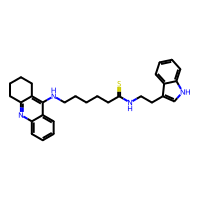
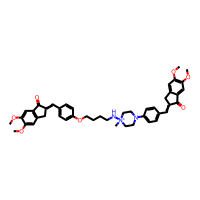
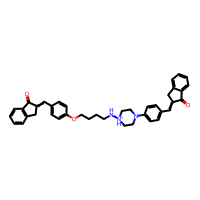
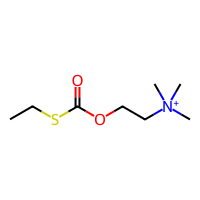
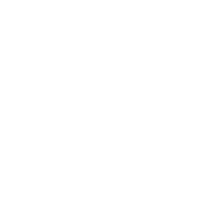
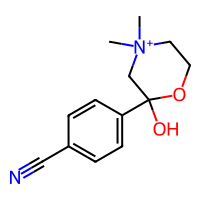
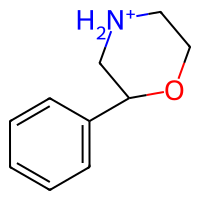
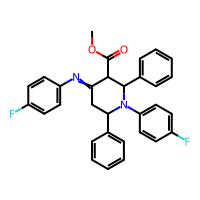
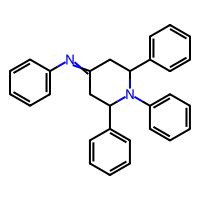
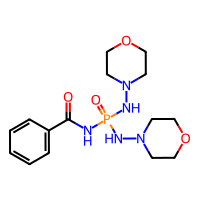
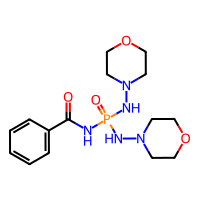
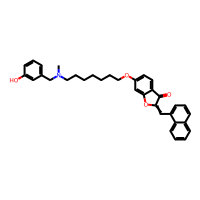
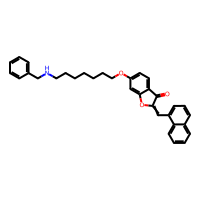

In [53]:
data

In [54]:
data['#Atoms MS'] = data['Murcko Scaffold'].apply(lambda x: x.GetNumAtoms())

,molecule_chembl_id,curated_smiles,class,Label,pIC50,ID,Molecule,Murcko Scaffold,#Atoms MS
0,CHEMBL4468781,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5cc(Cl)cc...,active,1,5.301030,,,,34
1,CHEMBL199670,O=C(CCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2...,active,1,5.301030,,,,35
2,CHEMBL199861,O=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.301030,,,,34
3,CHEMBL4469239,S=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.301030,,,,34
4,CHEMBL4780352,COc1cc2c(cc1OC)C(=O)C(=Cc1ccc(OCCCCN[N+]3(C)CC...,active,1,5.301030,,,,46
...,...,...,...,...,...,...,...,...,...
5458,CHEMBL102637,CCSC(=O)OCC[N+](C)(C)C,inactive,0,-7.000000,,,,0
5459,CHEMBL334938,C[N+]1(C)CCOC(O)(c2ccc(C#N)cc2)C1,inactive,0,-7.064000,,,,12
5460,CHEMBL3597055,COC(=O)C1C(=Nc2ccc(F)cc2)CC(c2ccccc2)N(c2ccc(F...,inactive,0,-7.179552,,,,31
5461,CHEMBL1276534,O=C(NP(=O)(NN1CCOCC1)NN1CCOCC1)c1ccccc1,inactive,0,-7.269980,,,,25

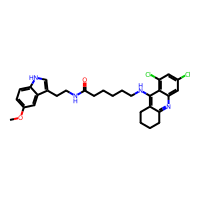
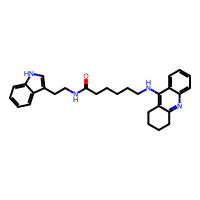
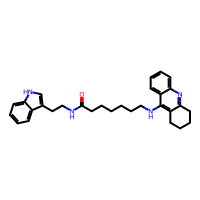
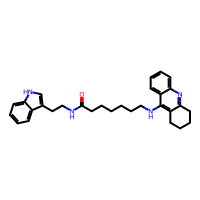
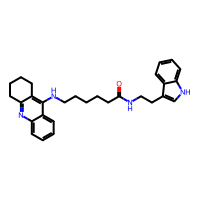
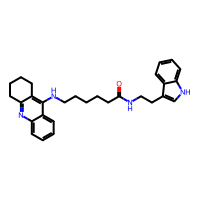
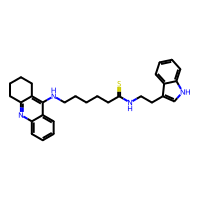
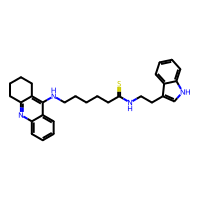
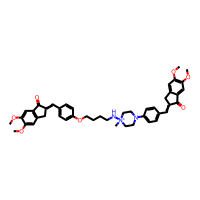
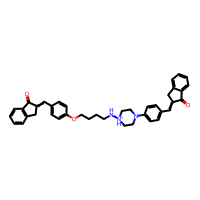
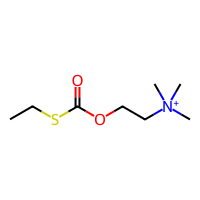
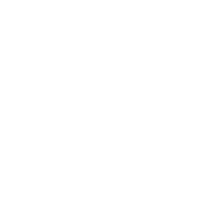
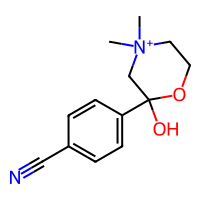
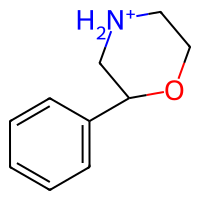
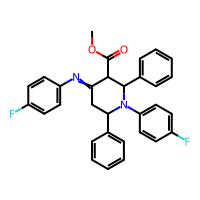
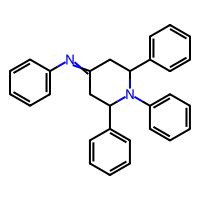
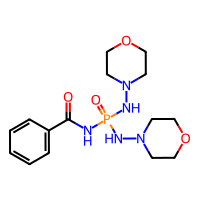
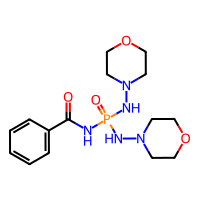
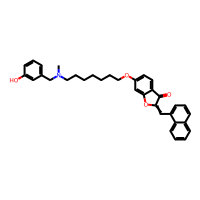
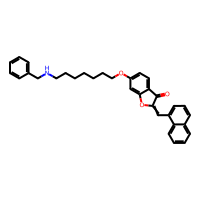

In [55]:
data

## 5. Butina Cluster

In [56]:
# Inspiration from Pat Walters: https://github.com/PatWalters/workshop/blob/master/clustering/taylor_butina.ipynb
# and Gashaw M. Goshu: https://github.com/gashawmg/Molecular-fingerprints/blob/main/Calculating%20molecular%20fingerprints%20available%20in%20RDkit%20.ipynb

def flexible_butina_cluster(data, cutoff=0.35, precomputed_fps=False, nBits=2048):
    """
    Cluster molecules using the Butina algorithm.

    Parameters:
    - data (list): List of molecules (as RDKit Mol objects) or fingerprints (as BitVects),
                  depending on precomputed_fps.
    - cutoff (float): Distance threshold for clustering.
    - precomputed_fps (bool): Flag to indicate if data contains precomputed fingerprints.
    - nBits (int): Number of bits for the fingerprint. Only relevant if fingerprints need to be computed.

    Returns:
    - list: List of cluster IDs corresponding to each molecule/fingerprint.

    Usage:
    1. If you have precomputed fingerprints:
       >>> results = flexible_butina_cluster(precomputed_fingerprints, precomputed_fps=True)

    2. If you have raw molecules and need to compute fingerprints:
       >>> results = flexible_butina_cluster(list_of_molecules)
    """

    # If fingerprints are not precomputed, compute them
    if not precomputed_fps:
        data = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=nBits) for m in data]

    # Calculate pairwise distances
    dists = []
    ndata = len(data)
    for i in range(1, ndata):
        sims = DataStructs.BulkTanimotoSimilarity(data[i], data[:i])
        dists.extend([1-x for x in sims])

    # Apply Butina clustering
    clusters = Butina.ClusterData(dists, ndata, cutoff, isDistData=True)
    cluster_id_list = [0]*ndata
    for idx, cluster in enumerate(clusters, 1):
        for member in cluster:
            cluster_id_list[member] = idx

    return cluster_id_list, data

In [57]:
cluster_id_list, fnp = flexible_butina_cluster(data['Murcko Scaffold'], precomputed_fps=False)

In [58]:
len(np.unique(cluster_id_list))

1119

In [59]:
data['Cluster'] = cluster_id_list

,molecule_chembl_id,curated_smiles,class,Label,pIC50,ID,Molecule,Murcko Scaffold,#Atoms MS,Cluster
0,CHEMBL4468781,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5cc(Cl)cc...,active,1,5.301030,,,,34,4
1,CHEMBL199670,O=C(CCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2...,active,1,5.301030,,,,35,4
2,CHEMBL199861,O=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.301030,,,,34,4
3,CHEMBL4469239,S=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.301030,,,,34,6
4,CHEMBL4780352,COc1cc2c(cc1OC)C(=O)C(=Cc1ccc(OCCCCN[N+]3(C)CC...,active,1,5.301030,,,,46,556
...,...,...,...,...,...,...,...,...,...,...
5458,CHEMBL102637,CCSC(=O)OCC[N+](C)(C)C,inactive,0,-7.000000,,,,0,23
5459,CHEMBL334938,C[N+]1(C)CCOC(O)(c2ccc(C#N)cc2)C1,inactive,0,-7.064000,,,,12,307
5460,CHEMBL3597055,COC(=O)C1C(=Nc2ccc(F)cc2)CC(c2ccccc2)N(c2ccc(F...,inactive,0,-7.179552,,,,31,46
5461,CHEMBL1276534,O=C(NP(=O)(NN1CCOCC1)NN1CCOCC1)c1ccccc1,inactive,0,-7.269980,,,,25,485

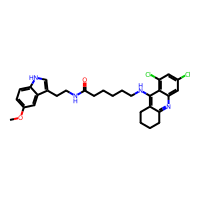
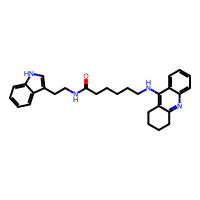
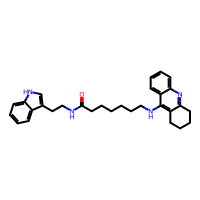
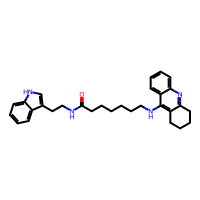
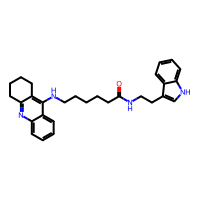
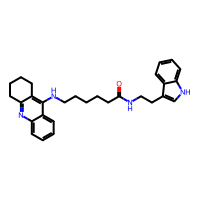
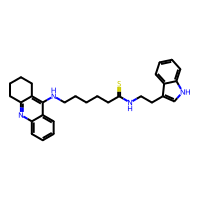
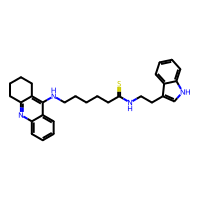
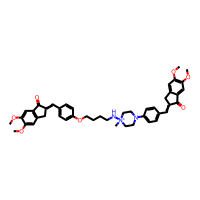
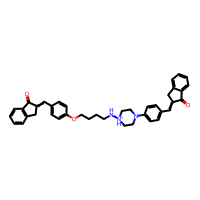
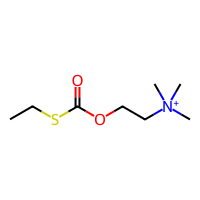
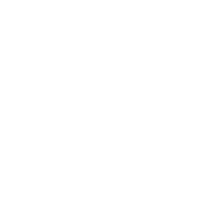
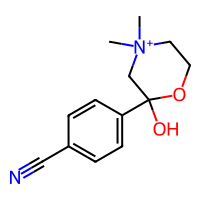
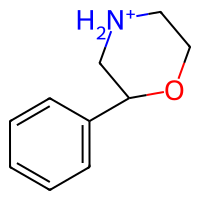
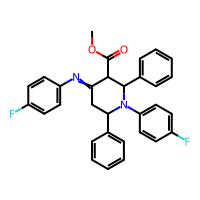
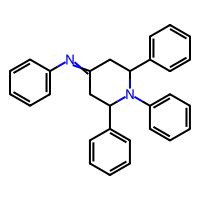
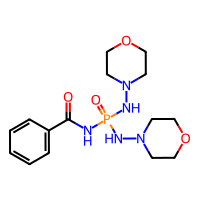
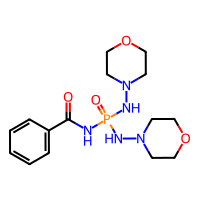
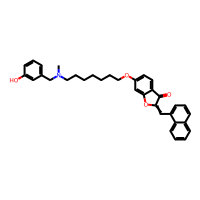
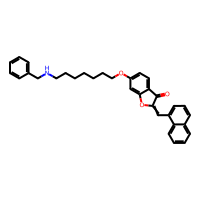

In [60]:
data

In [61]:
mols2grid.display(data, smiles_col='curated_smiles', mol_col='Murcko Scaffold',
                  subset=['Cluster'])

MolGridWidget()

## 6. Split Data: Train/Test

In [62]:
clusters = data.groupby('Cluster')['Molecule'].count()
clusters

Cluster
1       165
2       113
3        96
4        72
5        82
       ... 
1115      1
1116      1
1117      1
1118      1
1119      1
Name: Molecule, Length: 1119, dtype: int64

In [63]:
# Groups with more than 5 rows (more than 5 molecules)
train = data.groupby('Cluster').filter(lambda x: len(x) > 5)
train

,molecule_chembl_id,curated_smiles,class,Label,pIC50,ID,Molecule,Murcko Scaffold,#Atoms MS,Cluster
0,CHEMBL4468781,COc1ccc2[nH]cc(CCNC(=O)CCCCCNc3c4c(nc5cc(Cl)cc...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a737450>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fd770>,34,4
1,CHEMBL199670,O=C(CCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a737680>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fd7e0>,35,4
2,CHEMBL199861,O=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a7376f0>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fd700>,34,4
5,CHEMBL4556734,O=C(CCCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a737990>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fd930>,36,4
6,CHEMBL199585,O=C(CCCCCCNc1c2c(nc3cc(Cl)cc(Cl)c13)CCCC2)NCCc...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a737a00>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fd9a0>,35,4
...,...,...,...,...,...,...,...,...,...,...
5453,CHEMBL3597003,CCOC(=O)C1C(=Nc2ccccc2)CC(c2ccc(C)cc2)N(c2cccc...,inactive,0,-6.746634,,<rdkit.Chem.rdchem.Mol object at 0x7b7c296a3df0>,<rdkit.Chem.rdchem.Mol object at 0x7b7be6b13df0>,31,46
5455,CHEMBL4851865,Cc1cccc(CN2CCC(CNC(=O)c3cncc(NC(=O)c4ccnc(NC(=...,inactive,0,-6.803730,,<rdkit.Chem.rdchem.Mol object at 0x7b7c296a3f40>,<rdkit.Chem.rdchem.Mol object at 0x7b7be6b13ed0>,38,76
5458,CHEMBL102637,CCSC(=O)OCC[N+](C)(C)C,inactive,0,-7.000000,,<rdkit.Chem.rdchem.Mol object at 0x7b7c296c4120>,<rdkit.Chem.rdchem.Mol object at 0x7b7be6b140b0>,0,23
5460,CHEMBL3597055,COC(=O)C1C(=Nc2ccc(F)cc2)CC(c2ccccc2)N(c2ccc(F...,inactive,0,-7.179552,,<rdkit.Chem.rdchem.Mol object at 0x7b7c296c4200>,<rdkit.Chem.rdchem.Mol object at 0x7b7be6b14190>,31,46


In [64]:
test = data.groupby('Cluster').filter(lambda x: len(x) <= 5)
test

,molecule_chembl_id,curated_smiles,class,Label,pIC50,ID,Molecule,Murcko Scaffold,#Atoms MS,Cluster
3,CHEMBL4469239,S=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a7377d0>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fd850>,34,6
4,CHEMBL4780352,COc1cc2c(cc1OC)C(=O)C(=Cc1ccc(OCCCCN[N+]3(C)CC...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a7378b0>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fd8c0>,46,556
7,CHEMBL4467284,S=C(CCCCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c...,active,1,5.301030,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a737ae0>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fda10>,36,6
41,CHEMBL3585776,COc1ccc(C(C)NS(=O)(=O)NC(=O)OCc2ccccc2)cc1,active,1,1.571056,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a78d7e0>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fe8f0>,22,346
44,CHEMBL3585775,COc1ccccc1C(C)NS(=O)(=O)NC(=O)OCc1ccccc1,active,1,1.571056,,<rdkit.Chem.rdchem.Mol object at 0x7b7c2a78d9a0>,<rdkit.Chem.rdchem.Mol object at 0x7b7c0b2fea40>,22,346
...,...,...,...,...,...,...,...,...,...,...
5454,CHEMBL4763394,ON=Cc1cc(Cl)cc(CNc2ccc(N3CCOCC3)c(F)c2)c1O,inactive,0,-6.772102,,<rdkit.Chem.rdchem.Mol object at 0x7b7c296a3e60>,<rdkit.Chem.rdchem.Mol object at 0x7b7be6b13e60>,20,486
5456,CHEMBL335439,C[N+]1(C)CCOC(O)(c2ccc(Cl)cc2)C1,inactive,0,-6.910000,,<rdkit.Chem.rdchem.Mol object at 0x7b7c296c4040>,<rdkit.Chem.rdchem.Mol object at 0x7b7be6b13f40>,12,307
5457,CHEMBL1276594,O=P(NN1CCOCC1)(NN1CCOCC1)Oc1ccccc1,inactive,0,-6.980003,,<rdkit.Chem.rdchem.Mol object at 0x7b7c296c40b0>,<rdkit.Chem.rdchem.Mol object at 0x7b7be6b14040>,23,652
5459,CHEMBL334938,C[N+]1(C)CCOC(O)(c2ccc(C#N)cc2)C1,inactive,0,-7.064000,,<rdkit.Chem.rdchem.Mol object at 0x7b7c296c4190>,<rdkit.Chem.rdchem.Mol object at 0x7b7be6b14120>,12,307


In [65]:
train.to_csv('data_train.csv', index=False)

In [66]:
test.to_csv('data_test.csv', index=False)

In [67]:
PandasTools.WriteSDF(train, 'molecules_train.sdf', molColName = 'Molecule',
                     properties=train.columns)

In [68]:
PandasTools.WriteSDF(test, 'molecules_test.sdf', molColName = 'Molecule',
                     properties=train.columns)